# File and libraries

In [1]:
import pandas as pd
import numpy as np


filepath=r'data/df_merch_6_feat_eng_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

file_tag = "df_merch_balancing_input"

# DSLabs functions

In [2]:
%run "scripts/dslabs_functions.py"


# Data functions

In [3]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [4]:

test_data=True
# test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False


if test_data==True:

    data=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    data=data.sample(frac=0.05, replace=False)
    test=test.sample(frac=0.05, replace=False)
    train=train.sample(frac=0.05, replace=False)
    
    
else:
    data=pd.read_csv(f"{filepath}.csv")  
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)



 
target='returning_user'
vars: list[str] = data.columns.to_list()
labels: list = list(data[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)
test.sort_values(by='day_of_year', inplace=True)
train.sort_values(by='day_of_year', inplace=True)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 743351 entries, 0 to 743350
Data columns (total 40 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   device_category                  743351 non-null  float64
 1   device_mobile_model_name         743351 non-null  float64
 2   device_operating_system          743351 non-null  float64
 3   device_operating_system_version  743351 non-null  float64
 4   device_language                  743351 non-null  float64
 5   device_web_info_browser          743351 non-null  float64
 6   device_web_info_browser_version  743351 non-null  float64
 7   geo_region                       743351 non-null  float64
 8   geo_city                         743351 non-null  float64
 9   traffic_source_medium            743351 non-null  float64
 10  traffic_source_source            743351 non-null  float64
 11  engagement_time_msec             743351 non-null  float64
 12  month  

In [5]:
test.columns

Index(['device_category', 'device_mobile_model_name',
       'device_operating_system', 'device_operating_system_version',
       'device_language', 'device_web_info_browser',
       'device_web_info_browser_version', 'geo_region', 'geo_city',
       'traffic_source_medium', 'traffic_source_source',
       'engagement_time_msec', 'month', 'day_of_year', 'week_number',
       'page_path_level_1', 'page_path_level_2', 'page_path_level_3',
       'path_length', 'time_of_day_sin', 'time_of_day_cos', 'local_hour_sin',
       'local_hour_cos', 'local_minute_sin', 'local_minute_cos',
       'hour_minute_fraction_sin', 'hour_minute_fraction_cos', 'day_sin',
       'day_cos', 'day_of_week_nr_sin', 'day_of_week_nr_cos',
       'week_of_month_nr_sin', 'week_of_month_nr_cos', 'geo_country',
       'session_engaged', 'year', 'quarter', 'is_weekend', 'domain',
       'returning_user'],
      dtype='object')

# Balancing Analysis

Minority class= 1.0 : 191899
Majority class= 0.0 : 551452
Original class distribution:
returning_user
0.0    74.184605
1.0    25.815395
Name: proportion, dtype: float64



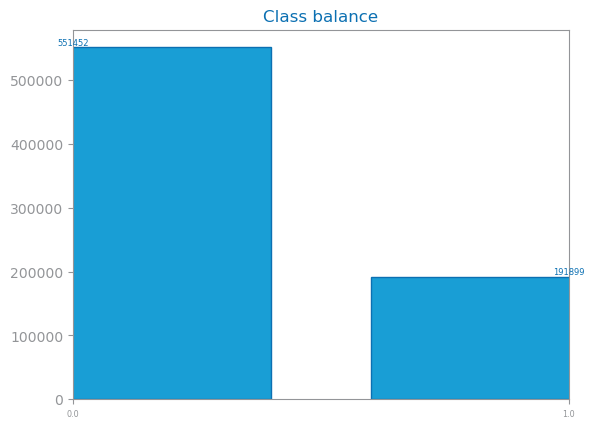

In [6]:
from pandas import read_csv, concat, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart


target_count: Series = data[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

print(f"Original class distribution:\n{data[target].value_counts(normalize=True) * 100}\n")


figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
show()

# Balance 1 - Undersampling

## Bal 1 strategy Application

In [7]:
from pandas import DataFrame, Series
from sklearn.preprocessing import StandardScaler



def apply_strategy_1(df: DataFrame) -> DataFrame:

    df_copy=df.copy()

    # this script is available in data_functions originally from DSLabs site in Outlier chapter

    # Ensure positive_class and negative_class are defined and match the target values
    positive_class = 1  # Or whatever your positive class value is
    negative_class = 0  # Or whatever your negative class value is

    # Separate the majority and minority classes
    df_majority = df_copy[df_copy[target] == negative_class]
    df_minority = df_copy[df_copy[target] == positive_class]

    # Check the class distribution
    print(f"Original class distribution:\n{df_copy[target].value_counts(normalize=True) * 100}\n")

    # Downsample the majority class to match the size of the minority class
    df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

    # Combine the downsampled majority class with the minority class
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

    # sort  the combined dataset
    df_balanced.sort_values(by='day_of_year', inplace=True)
    

    # Check the new class distribution to verify the balance
    print(f"Balanced class distribution:\n{df_balanced[target].value_counts(normalize=True) * 100}\n")

    
    return df_balanced


train_1=apply_strategy_1(train)
test_1=test.copy()



Original class distribution:
returning_user
0.0    73.421288
1.0    26.578712
Name: proportion, dtype: float64

Balanced class distribution:
returning_user
1.0    50.0
0.0    50.0
Name: proportion, dtype: float64



## Bal 1 train/test split 

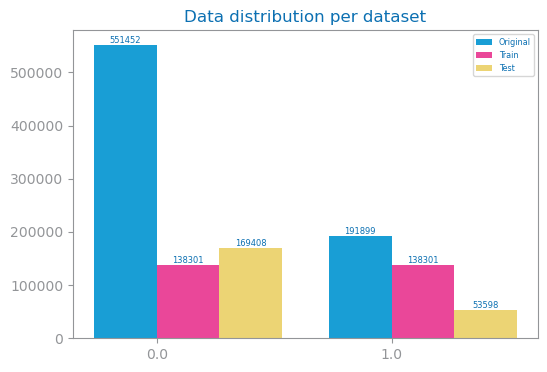

In [8]:
if evaluate==True:
    from pandas import concat
    from matplotlib.pyplot import figure, show
    from dslabs_functions import plot_multibar_chart


    # Distribution check


    # Create a dictionary to store original class counts
    values: dict[str, list[int]] = {
        "Original": [
            len(data[data[target] == 0]),  # Assuming 0 is the negative class
            len(data[data[target] == 1]),  # Assuming 1 is the positive class
        ]
    }

    values["Train"] = [
        len(train_1[train_1[target] == 0]),
        len(train_1[train_1[target] == 1]),
    ]
    values["Test"] = [
        len(test_1[test_1[target] == 0]),
        len(test_1[test_1[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Bal 1 evaluate

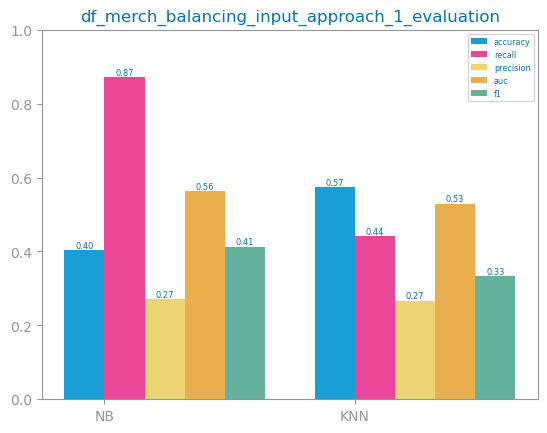

In [9]:
# evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
# removed Multinomial from run_NB function because dataset has negative values

if evaluate==True:
    figure()
    eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='returning_user', metric="recall")
    plot_multibar_chart(
        ["NB", "KNN"], eval_1, title=f"{file_tag}_approach_1_evaluation", percentage=True
    )
    savefig(f"images/{file_tag}_approach_1_evaluation.png")
    show()

# Bal 2 - Hybrid Sampling

Reduce from negative class from 75 to 60% and then oversample the positives into 50/50


## Bal 2 strategy aplication

In [11]:


def apply_strategy_2(df):

     # Create a copy of the dataframe
    df_copy = df.copy()

    # Define positive and negative classes
    positive_class = 1  # Modify as per your positive class value
    negative_class = 0  # Modify as per your negative class value

    # Separate the majority and minority classes
    df_majority = df_copy[df_copy[target] == negative_class]
    df_minority = df_copy[df_copy[target] == positive_class]

    # Check the current class distribution
    print(f"Original class distribution:\n{df_copy[target].value_counts(normalize=True) * 100}\n")

    # Sort by 'day_of_year' (or another time-related feature) to ensure the data is split based on time
    df_majority.sort_values(by='day_of_year', inplace=True)
    df_minority.sort_values(by='day_of_year', inplace=True)

    # Determine the number of majority samples for a the desired split
    total_samples = len(df_copy)
    desired_majority_size = int(0.6 * total_samples)

    # Keep the older data for majority class (downsampling based on time, not randomly)
    df_majority_downsampled = df_majority.head(desired_majority_size)

    # Upsample the minority class to match the new majority size for a 50/50 split
    upsample_size = len(df_majority_downsampled)
    df_minority_upsampled = df_minority.sample(n=upsample_size, replace=True)

    # Combine the downsampled majority and upsampled minority classes
    df_balanced = pd.concat([df_majority_downsampled, df_minority_upsampled])

    # Sort the dataset by 'day_of_year' again if needed
    df_balanced.sort_values(by='day_of_year', inplace=True)

    # Check the new class distribution
    print(f"Hybrid class distribution:\n{df_balanced[target].value_counts(normalize=True) * 100}\n")

    return df_balanced


train_2=apply_strategy_2(train)
test_2=test.copy()


Original class distribution:
returning_user
0.0    73.421288
1.0    26.578712
Name: proportion, dtype: float64

Hybrid class distribution:
returning_user
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64



In [12]:
# from numpy import ndarray
# from pandas import Series
# from imblearn.over_sampling import SMOTE


# SMOTE DRAFT   
# 
# # Copy the DataFrame
#     df_copy = df.copy()

#     # Define random state for reproducibility
#     RANDOM_STATE = 42

#     # Separate the features (X) and target (y)
#     y = df_copy.pop(target).values
#     X: ndarray = df_copy.values

#     # Initialize SMOTE
#     smote = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)

#     # Fit and resample
#     smote_X, smote_y = smote.fit_resample(X, y)

#     # Reconstruct the DataFrame from the SMOTE output
#     df_smote = concat([DataFrame(smote_X, columns=df_copy.columns), DataFrame(smote_y, columns=[target])], axis=1)


#     # Print class distribution and shape
#     smote_target_count: Series = Series(smote_y).value_counts()
#     print("Minority class=", smote_target_count.index[1], ":", smote_target_count[1])
#     print("Majority class=", smote_target_count.index[0], ":", smote_target_count[0])
#     print(
#         "Proportion:",
#         round(smote_target_count[1] / smote_target_count[0], 2),
#         ": 1",
#     )
#     print("Shape of the new DataFrame:", df_smote.shape)

#     print("Class counts after SMOTE:")
#     print(df_smote[target].value_counts())

#     return df_smote

## Bal 2 train/test split 

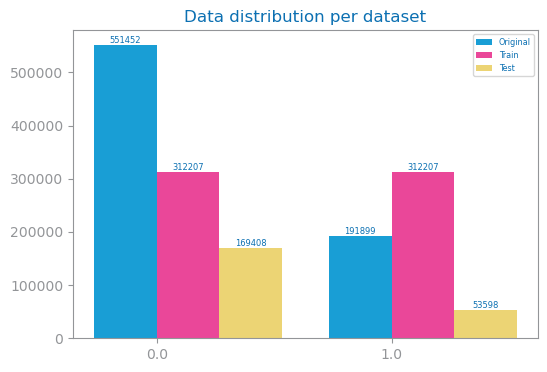

In [13]:
if evaluate==True:

    from pandas import concat
    from matplotlib.pyplot import figure, show
    from dslabs_functions import plot_multibar_chart


    # Distribution check


    # Create a dictionary to store original class counts
    values: dict[str, list[int]] = {
        "Original": [
            len(data[data[target] == 0]),  # Assuming 0 is the negative class
            len(data[data[target] == 1]),  # Assuming 1 is the positive class
        ]
    }

    values["Train"] = [
        len(train_2[train_2[target] == 0]),
        len(train_2[train_2[target] == 1]),
    ]
    values["Test"] = [
        len(test_2[test_2[target] == 0]),
        len(test_2[test_2[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Bal 2 evaluate

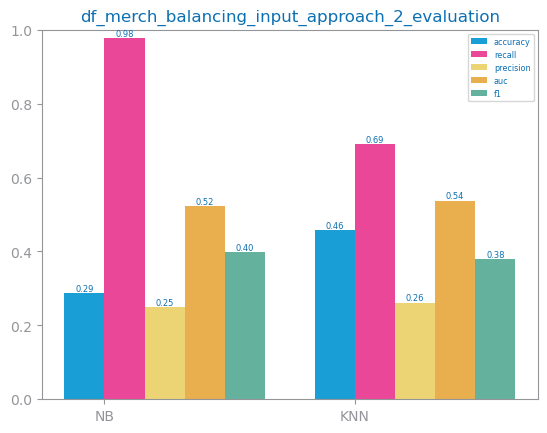

In [14]:
if evaluate == True:
    figure()
    eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='returning_user', metric="recall")
    plot_multibar_chart(
        ["NB", "KNN"], eval_2, title=f"{file_tag}_approach_2_evaluation", percentage=True
    )
    savefig(f"images/{file_tag}_approach_2_evaluation.png")
    show()

# Approach uplift comparison

## uplift df

In [15]:
algorithms = ['Naive Bayes', 'KNN']

# Create DataFrames for eval_1 and eval_2
df_eval_1 = pd.DataFrame(eval_1, index=algorithms)
df_eval_2 = pd.DataFrame(eval_2, index=algorithms)

# Calculate uplift
df_uplift = df_eval_2 - df_eval_1



# Combine everything into one DataFrame (without misalignment issues)
comparison_df = pd.concat([df_eval_1, df_eval_2, df_uplift], axis=1)
comparison_df.columns = pd.MultiIndex.from_product([['Approach 1', 'Approach 2', 'Uplift'], eval_1.keys()])



# Display the DataFrame
comparison_df

Approach 1                                         Approach 2  \
              accuracy    recall precision       auc        f1   accuracy   
Naive Bayes   0.403464  0.872085  0.270315  0.563643  0.412706   0.287409   
KNN           0.574473  0.441714  0.267071  0.529095  0.332876   0.457311   

                                                       Uplift            \
               recall precision       auc        f1  accuracy    recall   
Naive Bayes  0.977630  0.249386  0.523332  0.397399 -0.116055  0.105545   
KNN          0.690362  0.261630  0.536969  0.379455 -0.117163  0.248647   

                                           
            precision       auc        f1  
Naive Bayes -0.020929 -0.040310 -0.015307  
KNN         -0.005441  0.007874  0.046579

# Analysis



# save to csv

In [16]:
if test_data==False:
      
    data_save=apply_strategy_1(data)
        
    data_save.to_csv(f"data/df_merch_7_bal_input.csv", index=False)


    print(data_save.columns)



Original class distribution:
returning_user
0.0    74.184605
1.0    25.815395
Name: proportion, dtype: float64

Balanced class distribution:
returning_user
1.0    50.0
0.0    50.0
Name: proportion, dtype: float64

Index(['device_category', 'device_mobile_model_name',
       'device_operating_system', 'device_operating_system_version',
       'device_language', 'device_web_info_browser',
       'device_web_info_browser_version', 'geo_region', 'geo_city',
       'traffic_source_medium', 'traffic_source_source',
       'engagement_time_msec', 'month', 'day_of_year', 'week_number',
       'page_path_level_1', 'page_path_level_2', 'page_path_level_3',
       'path_length', 'time_of_day_sin', 'time_of_day_cos', 'local_hour_sin',
       'local_hour_cos', 'local_minute_sin', 'local_minute_cos',
       'hour_minute_fraction_sin', 'hour_minute_fraction_cos', 'day_sin',
       'day_cos', 'day_of_week_nr_sin', 'day_of_week_nr_cos',
       'week_of_month_nr_sin', 'week_of_month_nr_cos', 'geo_countr

## train test csv

In [17]:
if test_data==False:
       
    train_save,test_save=simple_split_df(data_save,sort_by='day_of_year')
    
    train_save.to_csv(f"data/df_merch_7_bal_input_train.csv", index=False)
    print(train.columns)
    
    test.to_csv(f"data/df_merch_7_bal_input_test.csv", index=False)
    print(test.columns)

Index(['device_category', 'device_mobile_model_name',
       'device_operating_system', 'device_operating_system_version',
       'device_language', 'device_web_info_browser',
       'device_web_info_browser_version', 'geo_region', 'geo_city',
       'traffic_source_medium', 'traffic_source_source',
       'engagement_time_msec', 'month', 'day_of_year', 'week_number',
       'page_path_level_1', 'page_path_level_2', 'page_path_level_3',
       'path_length', 'time_of_day_sin', 'time_of_day_cos', 'local_hour_sin',
       'local_hour_cos', 'local_minute_sin', 'local_minute_cos',
       'hour_minute_fraction_sin', 'hour_minute_fraction_cos', 'day_sin',
       'day_cos', 'day_of_week_nr_sin', 'day_of_week_nr_cos',
       'week_of_month_nr_sin', 'week_of_month_nr_cos', 'geo_country',
       'session_engaged', 'year', 'quarter', 'is_weekend', 'domain',
       'returning_user'],
      dtype='object')
Index(['device_category', 'device_mobile_model_name',
       'device_operating_system', 'devi